<h1 align="center"><b>Bayesify - A personal music taste analysis using Bayesian Networks</b> </h2>

<p align="center">
    <i>
    Napolitano Daniele, Master’s Degree in Artificial Intelligence, University of Bologna<br>
    <a href="mailto: daniele.napolitano4@studio.unibo.it"> daniele.napolitano4@studio.unibo.it</a><br>
    March 1, 2023<br>
    </i>
    <img src="bayesify_logo.png" alt="logo" width="400"/><br>
</p>

<h3 align="center"><b>Abstract</b></h3>
<p align="center">
<i>
    Modern streaming platforms are known for their ability to predict the preferences of their users. <br>The music industry in particular poses a complex challenge due to the vastness of different music genres and songs available.<br>
    This project aims to model a Bayesian Network from a dataset built by fetching Spotify's API personal data and to experiment with different queries and methods in order to find interesting relationships. <br>
    Finally, a use case scenario with the final model is presented.
</i>
</p>

### <b>Table of Contents</b>
1. [Domain](#1-domain)
    - 1.1 [Dataset analysis](#11-dataset-analysis)
2. [Model Creation](#2-model-creation)
    - 2.1 [Using domain knowledge](#21-using-domain-knowledge)
    - 2.2 [Learning the structure](#22-learning-bayesian-network-structure)
3. [Network Analysis](#3-network-analysis)  
    - 3.1 [Comparing the two models](#31-comparing-the-two-models)
    - 3.2 [CPD](#32-cpd)
    - 3.3 ["like" ancestral graph](#33-parents-of-like)
    - 3.4 [Sampling](#34-sampling)
4. [Inference](#4-inference)
    - 4.1 [Genre](#41-genre)
    - 4.2 [Like](#42-like)
    - 4.3 [Analyzing the influence of genre](#43-analyzing-the-influence-of-genre)
5. [Use Case Scenario](#5-use-case-scenario)
6. [Conclusion](#6-conclusion)

_[References](#references)_

## <b>1. Domain</b><a class="anchor" id=1-domain></a>
The project idea was initially inspired by a [Kaggle dataset](https://www.kaggle.com/datasets/bricevergnou/spotify-recommendation) $^{[1]}$.<br>
In a similar way, I have made myself a dataset with 300 songs I like and 300 I dislike, and commented the whole process in the notebook [Dataset.ipynb](https://github.com/danielenapo/Bayesify/blob/main/Dataset.ipynb).<br>
First, the csv dataset is imported:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pgmpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import dataset
data=pd.read_csv("spotifyData.csv")
data=data.drop(data.columns[0],axis=1)
genre_dict = { 1: 'country', 2:'trap',3:'edm', 4:'electronic', 5: 'funk', 6: 'rock', 7: 'hip hop', 8: 'soul', 9: 'r&b',  10: 'jazz', 11: "pop"}


The following is a brief description of the features in the dataset, taken by the official Spotify's API documentation pages $^{[2]}$:

- <b>like</b><br>
Binary value, 1 if I like the song, 0 otherwise.
- <b>genre</b><br>
The main genre of the artist, mapped into the following dictionary:
> { 1: 'country', 2: 'trap', 3: 'edm', 4: 'electronic', 5: 'funk', 6: 'rock', 7: 'hip hop', 8: 'soul', 9: 'r&b',  10: 'jazz', 11: 'pop'}
- <b>instrumentalness</b>:<br>
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". It is a binary value where 1 indicates that the song is probably instrumental, 0 otherwise.
- <b>danceability</b><br>
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0 is least danceable and 4 is most danceable.
- <b>energy</b><br>
Energy is a measure from 0 to 4 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- <b>loudness</b><br>
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db, but were mapped from 0 to 4.
- <b>acousticness</b><br>
A confidence measure from 0 to 4 of whether the track is acoustic. 4 represents high confidence that the track is acoustic.
- <b>valence</b><br>
A measure from 0 to 4 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- <b>tempo</b><br>
The overall estimated tempo of a track in beats per minute (BPM), transformed in the scale from 0 to 4. In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

### 1.1 Dataset analysis<a class="anchor" id="11-dataset-analysis"></a>
To give some contest, below there are some plots of the dataset, showing the distribution of the features of the dataset color-coded by the "like" feature.

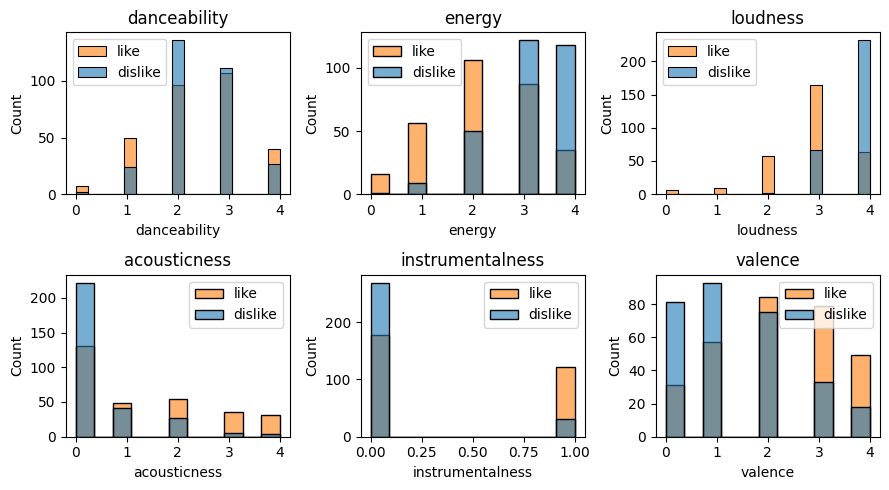

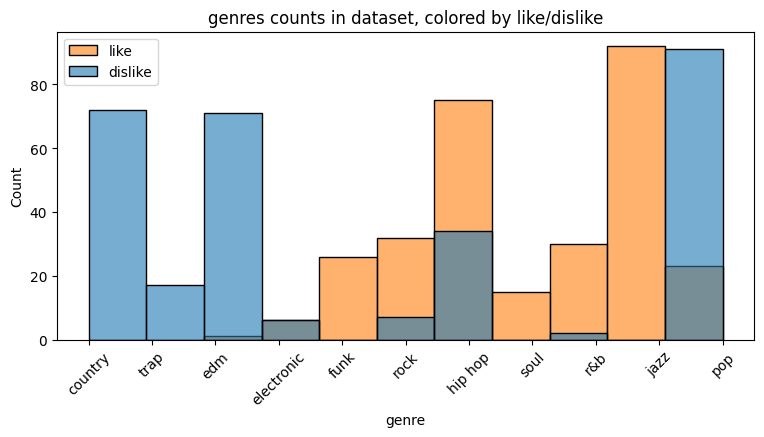

In [2]:
#show histogram of all features in a single plot, hue=like
fig, axes = plt.subplots(2, 3, figsize=(9, 5))
for i, ax in enumerate(axes.flat):
    sns.histplot(data=data, x=data.columns[i], hue='like', ax=ax, color=['red','blue'], alpha=0.6)
    ax.set(title=data.columns[i])
    ax.legend(['like','dislike'])
plt.tight_layout()
plt.show()
#histogram of genres
plt.figure(figsize=(9,4))
sns.histplot(data=data,x='genre',hue='like', alpha=0.6)
plt.xticks(np.arange(1,12),genre_dict.values(),rotation=45)
plt.title('genres counts in dataset, colored by like/dislike')
plt.legend(['like','dislike'])
plt.show()

## <b>2. Model Creation </b> <a class="anchor" id="2-model-creation"></a>
The main characteristic of a Bayesian Network is that it is a directed acyclic graph (DAG), where each node represents a random variable and each edge represents a conditional dependency between two random variables. The model is built by specifying the structure of the network and the conditional probability distributions (CPD) of each node.<br>
The [PGMpy](https://pgmpy.org/) library is used to build the model, to fill the CPDs and to make inferences.<br>
Two different networks will be implemented, one where the structure is designed with domain knowledge by me, and the other with the structure learned automatically from the data.<br>
### 2.1 Using domain knowledge  <a class="anchor" id="21-using-domain-knowledge"></a>

The model topology was designed using domain knowledge and intuition. Moreover, several trial and errors were needed in order to find an optimal model.<br>

In [3]:
from pgmpy.models import BayesianNetwork
from pgmpy.base import DAG

custom_dag=DAG([('genre', 'like'), ("instrumentalness", "genre"), ("acousticness", "loudness"), ("loudness", "energy"), ("energy", "valence"),
            ("tempo", "danceability"), ("loudness", "genre"), ("danceability", "valence")])
custom_model = BayesianNetwork([('genre', 'like'), ("instrumentalness", "genre"), ("acousticness", "loudness"), ("loudness", "energy"), ("energy", "valence"),
            ("tempo", "danceability"), ("loudness", "genre"), ("danceability", "valence")])

The `CPDs (Conditional Probability Distributions)` of the model were filled automatically by analyzing the dataset with `Maximum Likelihood Estimation (MLE)`.<br>

In [4]:
from pgmpy.estimators import MaximumLikelihoodEstimator
custom_model.fit(data, estimator=MaximumLikelihoodEstimator)

The graph below represents the network:

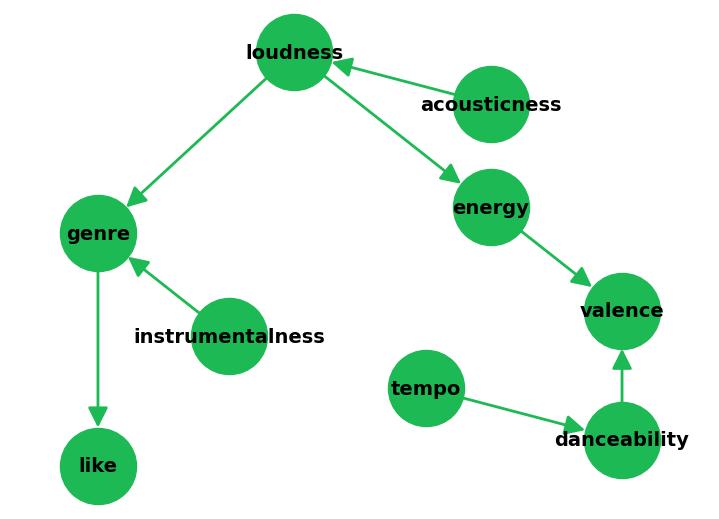

In [5]:
import networkx as nx
def print_network(model, pos):
    nx_graph = nx.DiGraph(model.edges())
    plt.figure(figsize=(7,5))
    nx.draw(nx_graph, with_labels=True, node_color='#1DB954', node_size=3000, alpha=1, arrowsize=30, font_size=14, font_weight='bold', pos=pos, width=2, edge_color='#1DB954')
    plt.show()
custom_pos= {'genre': [0.25, 0.5], 'like': [0.25, 0.05], 'instrumentalness': [0.27, 0.3], 'acousticness': [0.31, 0.75], 'loudness': [0.28, 0.85], 'energy': [0.31, 0.55], 
          'valence': [0.33, 0.35], 'tempo': [0.3, 0.2], 'danceability': [0.33, 0.1]}
print_network(custom_model, custom_pos)

### 2.2 Learning Bayesian Network structure <a class="anchor" id="22-learning-bayesian-network-structure"></a>
Using `Hill Climb Search` and `BDeu Score`, the network structure is learned automatically.


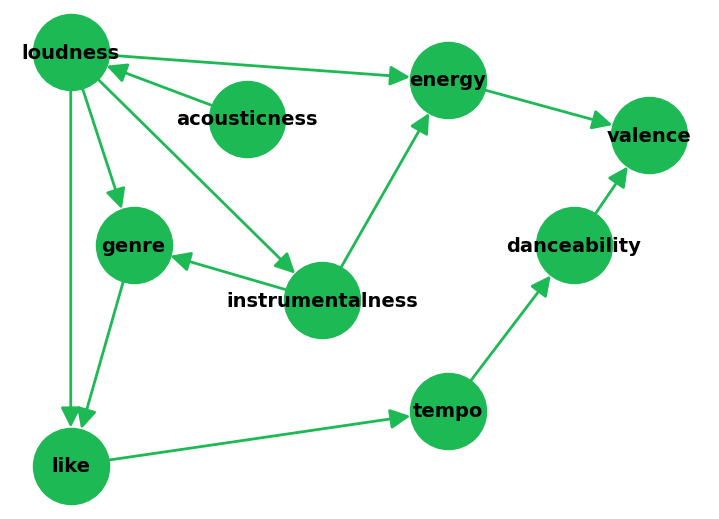

In [6]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore
hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BDeuScore(data), show_progress=False,  fixed_edges=custom_dag.edges )
#fit model and print
hc_model=BayesianNetwork(best_model.edges())
hc_model.fit(data, estimator=MaximumLikelihoodEstimator)
hc_pos= {'genre': [0.275, 0.5], 'like': [0.25, 0.1], 'instrumentalness': [0.35, 0.4], 'acousticness': [0.32, 0.73], 'loudness': [0.25, 0.85], 'energy': [0.4, 0.8], 
          'valence': [0.48, 0.7], 'tempo': [0.4, 0.2], 'danceability': [0.45, 0.5]}
print_network(best_model, hc_pos)


This new model has more links than the previous one, hence is more complex. For some links the algorithm drew the same conclusions as me (e.g. "genre" is linked to "like", and "instrumentalness" to "genre").<br> 
Although, there is a problem regarding causality: "like" is connected to "tempo". This makes no sense semantically, because the tempo of a song can't be a consequence of the fact that I like it or not.<br> 
In general, "like" should not be the cause of any other node.


## <b>3. Network analysis</b> <a class="anchor" id="3-network-analysis"></a>
PGMpy provides several methods that analyze and evaluate Bayesian Networks.<br>
In this section, the two models are analyzed in different ways, to better understand their topology and differences.


### 3.1 Comparing the two models<a class="anchor" id="31-comparing-the-two-models"></a>
Let's compare the BDeu scores of both models (the lower the score, the better the model):


In [7]:
from pgmpy.estimators import BDeuScore
print("BDeuScore for custom model: ", BDeuScore(data).score(custom_model))
print("BDeuScore for Hill Climb Search model: ", BDeuScore(data).score(hc_model))

BDeuScore for custom model:  -6439.986396841089
BDeuScore for Hill Climb Search model:  -6334.668699660097


Even if the values are almost equivalent, we get that the Hill Climb model is slightly worse. 
### 3.2 CPD
Let's analyze the CPD of the "like" node, to see if the model learned the correct parameters.


In [8]:
cpdLike=pd.DataFrame(custom_model.get_cpds("like").values)
cpdLike.columns=genre_dict.values()
print("CPD for like, custom model: ")
cpdLike

CPD for like, custom model: 


,country,trap,edm,electronic,funk,rock,hip hop,soul,r&b,jazz,pop
0,1.0,1.0,0.986111,0.5,0.0,0.179487,0.311927,0.0,0.0625,0.0,0.798246
1,0.0,0.0,0.013889,0.5,1.0,0.820513,0.688073,1.0,0.9375,1.0,0.201754


In [9]:
print("CPD for like, hill-climb search model: ")
print(hc_model.get_cpds("like"))


CPD for like, hill-climb search model: 
+----------+---------------+-----+---------------------+
| genre    | genre(1)      | ... | genre(11)           |
+----------+---------------+-----+---------------------+
| loudness | loudness(0.0) | ... | loudness(4.0)       |
+----------+---------------+-----+---------------------+
| like(0)  | 0.5           | ... | 0.8974358974358975  |
+----------+---------------+-----+---------------------+
| like(1)  | 0.5           | ... | 0.10256410256410256 |
+----------+---------------+-----+---------------------+


For the HC model, like depends on loudness other than genre, so the CPD has 3 dimensions. For this reason it was represented whit PGMpy's `TabularCPD` class, which is more suitable for this kind of CPD.


### 3.3 Ancestral graphs for "like" <a class="anchor" id="33-ancestral-graphs-for-like"></a>
The following graph shows the parents of the "like" node, in the two models. As we've seen in the complete graph, the HC model has more parents than the domain knowledge model.

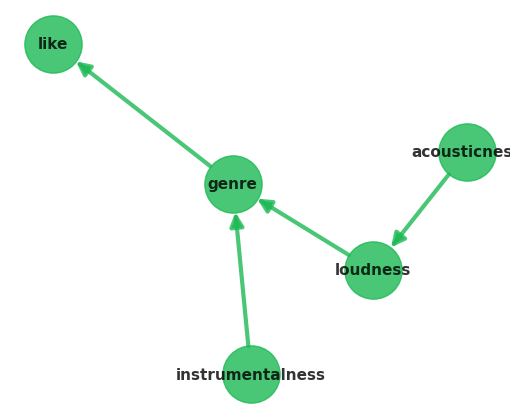

In [38]:
ancestral_graph_like=custom_model.get_ancestral_graph("like")
nx_graph2 = nx.DiGraph(ancestral_graph_like.edges())
plt.figure(figsize=(5,4))
nx.draw(nx_graph2, with_labels=True, node_color='#1DB954', node_size=1700, alpha=0.8, arrowsize=20, edge_color="#1DB954", font_size=11, font_weight='bold', width=3)
plt.show()

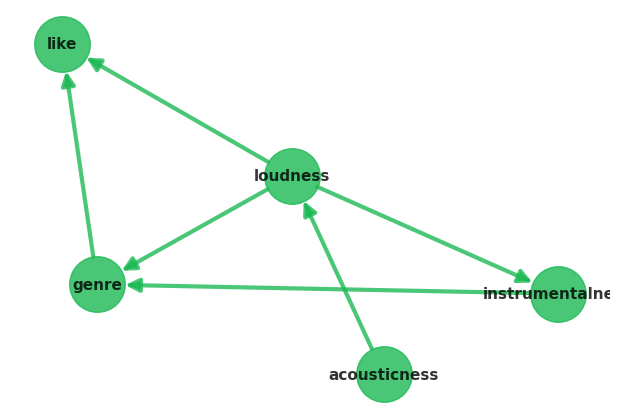

In [33]:
ancestral_graph_like=hc_model.get_ancestral_graph("like")
nx_graph2 = nx.DiGraph(ancestral_graph_like.edges())
plt.figure(figsize=(6,4))
nx.draw(nx_graph2, with_labels=True, node_color='#1DB954', node_size=1600, alpha=0.8, arrowsize=20, edge_color="#1DB954", font_size=11, font_weight='bold', width=3)
plt.show()


### <b> 3.4 Sampling </b> <a class="anchor" id="34-sampling"></a>
For reasons that will become clear in the next section, we want to try sampling from the model. We can do this using the `sample` method of the `BayesianModel` class.<br> 
The following code samples 10000 instances from the custom model, where the evidence is like=1, and the variable is genre.<br>

In [12]:
#sampling
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
infer_appr=BayesianModelSampling(custom_model)
q_appr=infer_appr.rejection_sample(evidence= [State('like', 1)], size=10000, show_progress=False)
print("Rejection sampling, custom model: ")
for i in np.unique(q_appr["genre"]):
    print(i, genre_dict[i], ":",q_appr.value_counts('genre')[i])


Rejection sampling, custom model: 
4 electronic : 5
5 funk : 343
6 rock : 1070
7 hip hop : 2517
8 soul : 242
9 r&b : 869
10 jazz : 2127
11 pop : 2827


It is evident that the pop class has the highest number of samples. But this contradicts the CPD of the "like" node, which says that the pop class has a much lower probability of being liked than the other classes.<br>


## <b>4. Inference</b> <a class="anchor" id="4-inference"></a>
Different queries are performed to infer the probability of certain features. Then, for each of them, different models/methods are tested and compared.<br>
Below is a function responsible of plotting a histogram of the results.


In [13]:
def plot_inference(queries, target, model, size=(10,5)):
    plt.figure(figsize=size)
    df=pd.DataFrame(columns=[target,'probability', 'model'])

    for q,m in zip(queries, model):
        n_var=q.get_cardinality([target])[target]
        for i in range(n_var):
            name=q.get_state_names(target, state_no=i)
            if target=='genre':
                name=genre_dict[name]
            df=df.append({target:name, 'probability':q.values[i], "model":m},ignore_index=True)
    sns.barplot(x=target,y='probability',data=df, hue="model")

### 4.1. Genre <a class="anchor" id="41-genre"></a>
We want to know the probability of a song to be of a certain genre, changing the evidence.
### $P(genre|like=1)$

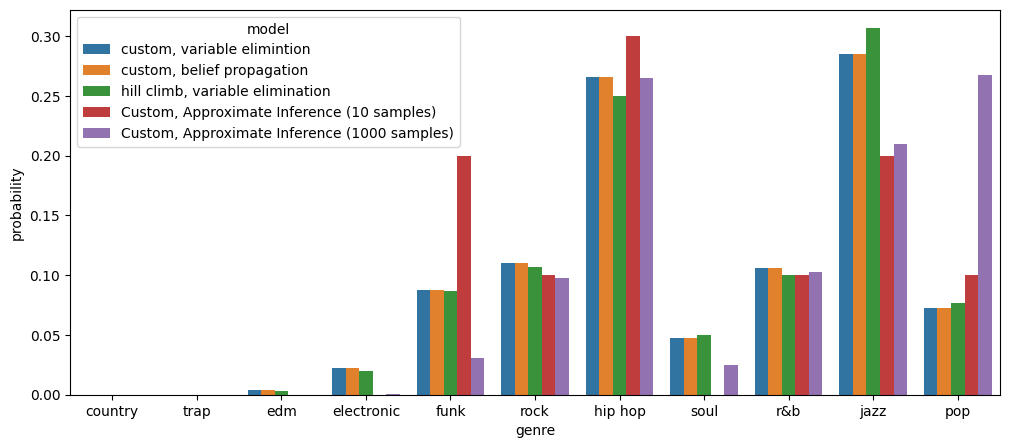

In [41]:
# make inference
from pgmpy.inference import VariableElimination
from pgmpy.inference import ApproxInference
from pgmpy.inference import BeliefPropagation

evidence={"like":1}
var=['genre']

#custom Variable elimination
infer_custom_ve=VariableElimination(custom_model)
q_custom_ve = infer_custom_ve.query(variables=var, evidence=evidence)
#custim belief propagation
infer_custom_bp=BeliefPropagation(custom_model)
q_custom_bp = infer_custom_bp.query(variables=var, evidence=evidence)
#hill climb
infer_hc=VariableElimination(hc_model)
q_hc= infer_hc.query(variables=var, evidence=evidence)
#approximate inference 10 samples
infer_appr=ApproxInference(custom_model)
q_appr=infer_appr.query(variables=var, evidence=evidence, n_samples=10, show_progress=False)
#approximate inference 1000 samples
q_appr2=infer_appr.query(variables=var, evidence=evidence, n_samples=1000, show_progress=False)
plot_inference([q_custom_ve,q_custom_bp,q_hc, q_appr, q_appr2], 'genre', 
               ['custom, variable elimintion', "custom, belief propagation",'hill climb, variable elimination', "Custom, Approximate Inference (10 samples)", "Custom, Approximate Inference (1000 samples)"], size=(12,5))



The results are similar to the distribution of genre by like, but the probability of pop is higher than expected for approximate inference.  Using a higher number of samples gives more extreme results.<br>
NOTE: PGMpy uses Rejection Sampling when performing approximate inference $^{[1]}$.
The problem is on the sampling, as seen in section [3.4](#34-sampling).<br>

### $P(energy|genre)$, for each genre
This time let's try to analyze the the musical features alone, without considering "like". In this example the inference is on "energy" (range [0,4]), given "genre" as evidence, and repeat for each genre.<br>
The probabilities are shown in a heatmap plot, where the X axis represents the energy value, Y the genre, and the color represents probability (the darker the higher).<br>
I'm using only Variable Elimination method, first applyed to the Custom model, then for the Hill Climb one.<br>

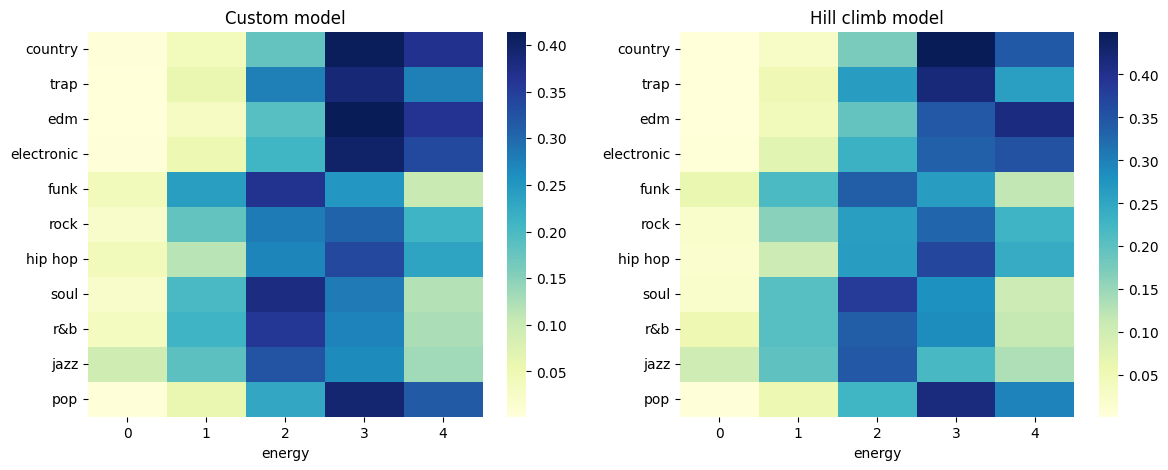

In [15]:
var=['energy']
results=[]
results2=[]
for i in genre_dict.keys():
    evidence={"genre":i}
    #custom
    infer_custom_ve=VariableElimination(custom_model)
    q_custom_ve = infer_custom_ve.query(variables=var, evidence=evidence)
    results.append(q_custom_ve.values)
    #hc
    infer_hc=VariableElimination(hc_model)
    q_hc= infer_hc.query(variables=var, evidence=evidence)
    results2.append(q_hc.values)
# heatmap plot where x is genre, y is energy, and color is probability
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Custom model")
sns.heatmap(results, xticklabels=np.arange(5), yticklabels=genre_dict.values(), cmap="YlGnBu")
plt.xlabel(var[0])
plt.subplot(1,2,2)
plt.title("Hill climb model")
sns.heatmap(results2, xticklabels=np.arange(5), yticklabels=genre_dict.values(), cmap="YlGnBu")
plt.xlabel(var[0])
plt.show()



The results are similar, though it's important to notice that the color scale is different.<br>
It's evident that Country, EDM, electronic and pop music are the most energetic genres in the dataset.

### 4.2 Like <a class="anchor" id="42-like"></a>

Now let's see the probability of like, given all the other features.<br>
The evidence used below is taken from a song I like, so I'm expecting that the result will be close to 1, or at least higher than 0.5.

Text(0.5, 1.0, "Inference for 'like'")

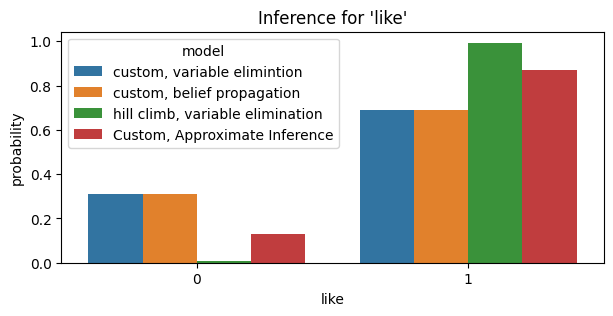

In [16]:
evidence={'danceability': 1.0, 'energy': 1.0, 'acousticness': 4.0, 'instrumentalness': 0, 'valence': 0.0, 'tempo': 4.0, 'genre': 7.0} 
var=['like']
#custom Variable elimination
infer_custom_ve=VariableElimination(custom_model)
q_custom_ve = infer_custom_ve.query(variables=var, evidence=evidence)
#custim belief propagation
infer_custom_bp=BeliefPropagation(custom_model)
q_custom_bp = infer_custom_bp.query(variables=var, evidence=evidence)
#hill climb
infer_hc=VariableElimination(hc_model)
q_hc= infer_hc.query(variables=var, evidence=evidence)
#approximate inference
infer_appr=ApproxInference(custom_model)
q_appr=infer_appr.query(variables=var, evidence=evidence, n_samples=100, show_progress=False)
plot_inference([q_custom_ve,q_custom_bp,q_hc, q_appr], 'like', ['custom, variable elimintion', "custom, belief propagation",'hill climb, variable elimination', "Custom, Approximate Inference"], size=(7,3))
plt.title("Inference for 'like'")


This time, approximate inference took much longer to sample the results, but gave similar results to the exact inferences. Belief propagation still gave the same results as variable elimination.<br>

###  4.3. Analyzing the influence of genre  <a class="anchor" id="43-analyzing-the-influence-of-genre"></a>
Now, we want to examine how much the genre impacts the results: We are going to use the Exact Inference method first on the custom model, then on the Hill Climb one.<br>
The other features will be the same as the last query (so from a song I like), but I will artificially change the genre to 11 (pop), which is a class that has a low probability of being liked.<br>


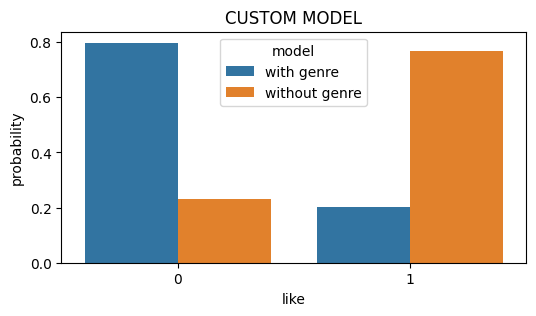

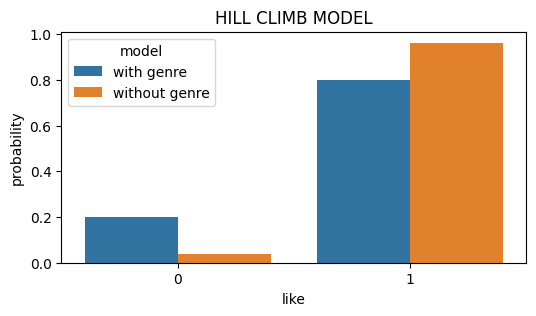

In [17]:
evidence1={'danceability': 1.0, 'energy': 1.0, 'acousticness': 4.0, 'instrumentalness': 0, 'valence': 0.0, 'tempo': 4.0, 'genre': 11.0} 
evidence2={'danceability': 1.0, 'energy': 1.0, 'acousticness': 4.0, 'instrumentalness': 0, 'valence': 0.0, 'tempo': 4.0}
#CUSTOM
infer_custom_ve=VariableElimination(custom_model)
q1 = infer_custom_ve.query(variables=var, evidence=evidence1)
q2 = infer_custom_ve.query(variables=var, evidence=evidence2)
#HC
infer_hc=VariableElimination(hc_model)
q3 = infer_hc.query(variables=var, evidence=evidence1)
q4 = infer_hc.query(variables=var, evidence=evidence2)
plot_inference([q1,q2], 'like', ['with genre', "without genre"], size=(6,3))
plt.title("CUSTOM MODEL")
plot_inference([q3,q4], 'like', ['with genre', "without genre"], size=(6,3))
plt.title("HILL CLIMB MODEL")
plt.show()



It is important to notice that genre has a very strong influence for the custom model (in fact it's the only feature that directly influences "like"): the results are totally different when not considering the genre (gets it wrong when genre is considered, then gets it right when it can only look at the other features).<br>
The Hill Climb model, on the other hand, was able to give a good result even without considering genre, but returns a probability close to one when genre is not considered. Still it's way less biased than the custom model, and the two results are more consistent with each other.
## <b>5. Use case scenario</b> <a class="anchor" id="5-use-case-scenario"></a>
It's time to apply the knowledge gained through the experiments to prototype a use case application.<br>
Given a song name and artist, an API call is performed to retrieve its features. The model will return the probability of the likeness, given the preprocessed features as evidence.
<br>
This mimics what Spotify does when evaluating if a song is a good match for a user, based on his listening history (but of course it's much more complex than that).

For some artists, genre is not available, but the model will still be able to make inference based on the other features.


In [42]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from IPython.display import display, Markdown
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
client_id = "*****" #insert client id
client_secret = "*****" #insert client secret
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri="http://localhost:8888/callback"))

def preprocessing(track_features):
    #read raw data, removing like and genre column from it
    rawData=pd.read_csv("RawData.csv") #raw unprocessed data is necessary for discretization
    rawData=rawData.drop(["like", "genre"], axis=1)
    if 'genre' in rawData.columns:
        rawData=rawData.drop(["genre"], axis=1)
    df=(pd.DataFrame(track_features))
    df.drop(['type','id','uri','track_href','analysis_url','time_signature', 'key', 'mode', 'speechiness', 'liveness', 'duration_ms'],axis=1,inplace=True)
    # scale data with minmaxscaler
    scaler = MinMaxScaler()
    rawData=rawData.append(df, ignore_index=True)   #add df to rawData as last entry                
    rawData[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']] = scaler.fit_transform(rawData[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']])
    # discretization using KBinsDiscretizer
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    rawData[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']] = est.fit_transform(rawData[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']])
    rawData['instrumentalness']= rawData["instrumentalness"].apply(lambda x: 1 if x>0.25 else 0)
    df=rawData.tail(1)
    rawData=0
    df=df.drop(df.columns[0], axis=1)
    return df

#taken from dataset.ipynb, function to find the genre of the song's artist from a list of 10 possible genres (genre_dict)
def enumerate_genre(genres):
    g=0
    for genre in genres:
        for key, value in genre_dict.items():
            if value in genre:
                g = key
        if g!=0:
            break
    return g

#function to get the track features from spotify given song name and artist
def retrieve_song(song_name, artist_name, verbose=False):
    #get the track id
    track_id = sp.search(q='track:' + song_name + ' artist:' + artist_name, type='track')
    track_id = track_id['tracks']['items'][0]['id']
    track_features = sp.audio_features(track_id)
    track_link = sp.track(track_id)['external_urls']['spotify']
    #get album image and name
    album_id=sp.track(track_id)['album']['id']
    album_image_link=sp.album(album_id)['images'][0]['url']
    album_name=sp.album(album_id)['name']
    #add genre
    artist_id=sp.track(track_id)['artists'][0]['id']
    track_genre =sp.artist(artist_id)['genres']
    if verbose:
        print("artist genres:", track_genre)
    g=enumerate_genre(track_genre)
    if(g!=0 and g!=np.nan):
        track_features[0]['genre']=g
    df= preprocessing(track_features)
    return df, album_image_link, album_name, track_link

def inference(name, artist, verbose=False, genre=True):
    df_song, album_image_link, album_name, track_link =retrieve_song(name, artist, verbose)
    song_dict=df_song.to_dict(orient='records')[0]
    if verbose:
        print("dictionary of song features: ", song_dict, "\n")
    song_dict.pop('loudness') #REMOVE LOUDNESS -> breaks everything
    if not genre:
        song_dict.pop('genre')
    infer_hc=VariableElimination(hc_model)
    q_hc = infer_hc.query(variables=['like'], evidence=song_dict)
    infer_custom=VariableElimination(custom_model)
    q_custom = infer_custom.query(variables=['like'], evidence=song_dict)
    # outputs
    plot_inference([q_custom, q_hc], 'like', ['custom', "hill climb"], size=(6,3))
    plt.title("Probability of like, with custom and hill climb models")
    plt.axhline(y=(q_custom.values[1]+q_hc.values[1])/2, color='r', linestyle='--', label="mean")
    plt.legend()
    display(Markdown("# There is a <b>{:.2f}%</b> chance that I like <br> <a href='{}'>_'{}'_ by _'{}'_</a>".format(((q_custom.values[1]+q_hc.values[1])/2)*100, track_link, name, artist)))
    display(Markdown("#### Album: _'{}'_".format(album_name)))
    display(Markdown("<image src='{}' width='300' height='300'>".format(album_image_link)))

# There is a <b>90.97%</b> chance that I like <br> <a href='https://open.spotify.com/track/7aE5WXu5sFeNRh3Z05wwu4'>_'Wish You Were Here'_ by _'Pink Floyd'_</a>

#### Album: _'Wish You Were Here (Remastered Version)'_

<image src='https://i.scdn.co/image/ab67616d0000b273df3aa3f27dfda3285ca7a2e5' width='300' height='300'>

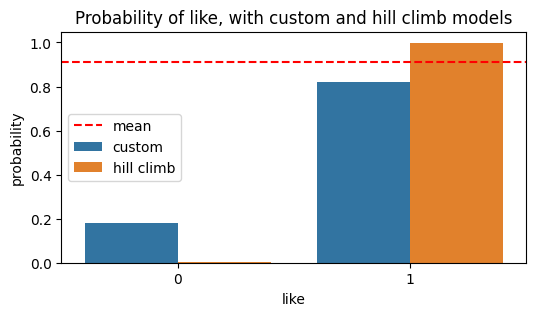

In [43]:
name="Wish You Were Here"
artist="Pink Floyd"
inference(name, artist)

I have experimented with different songs not included in the dataset, and the models provide good estimates most of the time.<br>

## <b>6. Conclusion</b> <a class="anchor" id="6-conclusion"></a>
The final models are simplistic (also due to the discretization and naive assumptions when building the dataset), but they still provided interesting insights on relationships between features.<br>
The model I have built may represent correctly my personal musical tastes, but it might not perform as well with someone else's music data: the causal relationships I have modeled are based on my preferences, which are mostly _subjective_ (i.e. some people might not care as much about genre, or only like happy songs, making the existing causal links not valid).
The same thing can be said about the hill-climb model: it was generated by looking exclusively at my data, so it probably cannot generalize well with other people. Besides, this model could not even work with myself in the future, as musical taste can change over time.<br>


Experimenting with Bayesian Networks offered insights for advantages and disadvantages of each method. Additionally, building the dataset from scratch was useful to better understand the data, and really helped in the process of designing the causal network.

# References <a class="anchor" id="references"></a>
1. [Kaggle dataset](https://www.kaggle.com/datasets/bricevergnou/spotify-recommendation)
2. [Spotify API documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)
3. [PGMpy Sampling source code](https://pgmpy.org/_modules/pgmpy/models/BayesianNetwork.html#BayesianNetwork.simulate)
4. [PGMpy rejection sampling source code](https://pgmpy.org/_modules/pgmpy/sampling/Sampling.html#BayesianModelSampling.rejection_sample)
